In [1]:
%load_ext dotenv
%dotenv

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # messages は list 型であり、 
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

In [3]:
import os
from langchain.chat_models import init_chat_model

os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OPENAI_ENDPOINT")
os.environ["OPENAI_API_VERSION"] = os.getenv("API_VERSION")

llm = init_chat_model(
    "azure_openai:gpt-4o",
    azure_deployment=os.environ["DEPLOYMENT_NAME"],
)

In [4]:
resp = llm.invoke("Hello, world!")
type(resp)

langchain_core.messages.ai.AIMessage

In [12]:
from typing import Any
def chatbot(state: State) -> dict[str, Any]:
    # state に入っているメッセージに対して応答を生成して、辞書（実質 State）として返す
    return {"messages": llm.invoke(state["messages"])}

In [6]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

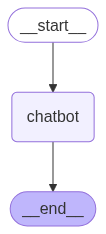

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
# LangGraph Streamによる実行処理を定義
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

stream_graph_updates("こんにちは")

TypeError: 'AIMessage' object is not subscriptable

In [19]:
state = {"messages": [("user", "こんにちは")]}
res = graph.invoke(state)
res["messages"][-1].content

'こんにちは！ 😊  \n今日はどんなお手伝いをしましょうか？'